# Data for Good: predicting suicidal behavior likelihood among Reddit users using Deep Learning (Part 5)

*Deep Learning and Reinforcement Learning (part of IBM Machine Learning Professional Certificate) - Course Project.*

>*No one is useless in this world who lightens the burdens of another.*  
― **Charles Dickens**

<img src='https://www.discover-norway.no/upload/images/-development/header/desktop/kul_munch/edvard%20munch%20the%20scream%201893_munchmmuseet.jpg'></img>

## Table of contents
1. [Data Preparation](#preparation)  
2. [Model Development: Recurrent Neural Network](#model)  
  2.1. [...](#kmeans)  
  2.2. [...](#hac)  
  2.3. [...](#dbscan)  
3. [Results](#results)  
4. [Discussion](#discussion)  
5. [Conclusion](#conclusion)  
  5.1. [Project Summary](#summary)  
  5.2. [Outcome of the Analysis](#outcome)  
  5.3. [Potential Developments](#developments)

## 1. Data Preparation <a name=preparation></a>

Steps to process the data for modeling:
1. Drop not-relevant features.
2. Remove stopwords from data.
3. Split dataset into training and testing sets.
4. Tokenize the posts.
5. Pad the sequences.

In [1]:
#Import needed libraries
import keras
import pandas as pd
import random
from random import randrange, seed
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from wordcloud import STOPWORDS

In [2]:
#Import data (after cleaning and the EDA perfomed in word-cloud environment notebook)
data = pd.read_csv(r'data.csv')
processed_data = data.copy()
processed_data.head()

,User,Post,Label,word_count,Post_nostopwords,class
0,user-0,its not a viable option and youll be leaving y...,Supportive,134,viable option leaving wife behind youd pain be...,0
1,user-1,it can be hard to appreciate the notion that y...,Ideation,2163,appreciate notion meet deeply boyfriend desire...,1
2,user-2,hi so last night i was sitting on the ledge of...,Behavior,470,hi night sitting ledge window contemplating wh...,1
3,user-3,i tried to kill my self once and failed badly ...,Attempt,885,tried kill self failed badly cause moment want...,1
4,user-4,hi nem3030 what sorts of things do you enjoy d...,Ideation,208,hi nem3030 sorts enjoy personally welcome musi...,1


##### 1. Drop not-relevant features.

In [3]:
#Drop not relevant features
processed_data.drop(['User', 'word_count', 'Label', 'Post_nostopwords'], axis=1, inplace=True)
processed_data.tail()

,Post,class
495,its not the end it just feels that way or at l...,0
496,it was a skype call but she ended it and ventr...,0
497,that sounds really weird maybe you were distra...,0
498,dont know there as dumb as it sounds i feel hy...,1
499,gt it gets better trust me ive spent long enou...,1


###### 2. Remove the stop words.

In [4]:
print("First 50 stop words:\n", list(STOPWORDS)[:51])

First 50 stop words:
 ['an', 'a', 'otherwise', 'been', 'her', 'above', 'no', 'theirs', 'would', "we're", 'myself', "when's", 'it', 'again', "here's", "why's", 'therefore', 'and', 'could', "wouldn't", 'not', "let's", 'same', 'your', 'for', 'yours', 'ever', 'who', 'when', 'of', "i'm", "don't", 'com', 'from', "how's", 'to', "she'd", "weren't", 'so', "there's", "you've", 'me', 'some', 'having', 'are', 'hers', 'as', 'they', 'where', 'between', "it's"]


In [5]:
#let's visualize a random post
random.seed(3)
processed_data.loc[randrange(500)]['Post']

'no more ideas i dont agree with live for others kind of advice i think you should live for yourself and your friends and family the world isnt going to be fixed any time soon so stop thinking its all on your shoulders regular exercise and a lack of excessive stress is important to a good life so is a decent job work is now stressful yes its never done im on a long break now its tired hot and humid where i now live so i cant really do anything i cant handle the heat well i want to prepare for my death before i go back to work its not only that the career enabled me to live a certain lifestyle and live in a certain place and not have to worry too much about money and other things why would you like that i dont think there are any other kinds of job i could do in this country it has been 5 years since i lost my job i have tried my best the things i lost in my life i believe them to be extremely fundamental and important things i also lost a life that had little worry and stress now i hav

In [6]:
random.seed(3)
print('Length of the post before removing the stop words:', len(processed_data.loc[randrange(500)]['Post']))

Length of the post before removing the stop words: 2269


In [7]:
#let's remove the stop words
processed_data['Post']=processed_data['Post'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [8]:
random.seed(3)
processed_data.loc[randrange(500)]['Post']

'ideas dont agree live others kind advice think live friends family world isnt going fixed time soon stop thinking shoulders regular exercise lack excessive stress important good life decent job work now stressful yes never done im long break now tired hot humid now live cant really anything cant handle heat well want prepare death go back work career enabled live certain lifestyle live certain place worry much money things dont think kinds job country 5 years lost job tried best things lost life believe extremely fundamental important things lost life little worry stress now job gets worse every day doesnt allow time exercise boiling hot city saps energy horrible bitchy colleagues norm come realize really liked living country kind still jobs will worse live world shitty jobs one best jobs world threw away cant tolerate job isnt good say rest move different job industry city time less hot humid place wont good climate city even ill still lost years life people dont understand suicide a

In [9]:
random.seed(3)
print('Length of the post after removing the stop words:', len(processed_data.loc[randrange(500)]['Post']))

Length of the post after removing the stop words: 1369


###### 3. Split the dataset into training and testing sets.

Let's split the dataset into train and test sets. I use 20% of the dataset (100 observations) as test data, and the stratify parameter to preserve the class imbalance.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(processed_data['Post'], processed_data['class'], test_size=0.2,
                                                    random_state=666, stratify = processed_data['class'])

In [11]:
print('Training dataset shape:', x_train.shape)
print('Testing dataset shape:', x_test.shape)
print('Training label shape:', y_train.shape)
print('Testing label shape:', y_test.shape)

Training dataset shape: (400,)
Testing dataset shape: (100,)
Training label shape: (400,)
Testing label shape: (100,)


###### 3. Tokenize the text.

I am going to tokenize the posts, that is I'll turn each user's posts into a list of individual words and then convert the words into integers, using the Keras Tokenizer class.

In [12]:
#let's create a tokenizer object with a token for out-of-vocabulary words
tokenizer = Tokenizer(oov_token='OOV')

In [13]:
#let's fit the tokenizer on the training set only
tokenizer.fit_on_texts(x_train)

In [14]:
#let's visualize a random post from the training set
random.seed(13)
x_train.reset_index(inplace=False, drop=True)[randrange(400)]

'dont much currently lifeguard bit cash im heading school september pretty much whether something want idea currently never feel anything used make happy years happy minutes guess making things programming art stuff havent able concentrate much anything will plan something lose drive dont follow though building really closest pool 15 25 minute drive guess try going every swam much long didnt much appeal last two seasons competed last years estimated swimming somewhere around 3 million yards year dont really feel going back actually lab animals dont make feel better better shape people used swim 2 4 hours day five days week dont anymore im still physically healthy blood test nothing showed take multivitamin eat fairly well honestly dont know guess something wrong brain functions im really stressed never bee one worry much lately ive wishing way though medication death whatever medicines never worked well anti depressants ive taken done fuck guess friends finding will everyday hard let a

In [15]:
#convert text into lists of integers for the training set
x_train = tokenizer.texts_to_sequences(x_train)

In [16]:
#let's visualize the same post after tokenizing
random.seed(13)
x_train[randrange(400)]

[3,
 27,
 671,
 10748,
 143,
 3200,
 2,
 3495,
 81,
 4670,
 145,
 27,
 391,
 26,
 9,
 245,
 671,
 49,
 8,
 48,
 237,
 25,
 80,
 64,
 80,
 682,
 211,
 206,
 13,
 1967,
 720,
 200,
 156,
 114,
 2404,
 27,
 48,
 6,
 460,
 26,
 372,
 630,
 3,
 730,
 71,
 1272,
 12,
 1737,
 3733,
 763,
 1153,
 1410,
 630,
 211,
 34,
 22,
 98,
 6183,
 27,
 79,
 72,
 27,
 2343,
 160,
 173,
 5691,
 10749,
 160,
 64,
 10750,
 2845,
 453,
 92,
 324,
 1754,
 10751,
 123,
 3,
 12,
 8,
 22,
 58,
 116,
 10752,
 1877,
 3,
 25,
 8,
 19,
 19,
 1337,
 5,
 237,
 2485,
 261,
 481,
 411,
 55,
 961,
 155,
 480,
 3,
 229,
 2,
 41,
 843,
 653,
 1231,
 1158,
 89,
 1495,
 43,
 10753,
 768,
 1273,
 39,
 293,
 3,
 4,
 211,
 26,
 180,
 417,
 7239,
 2,
 12,
 5176,
 49,
 10754,
 16,
 656,
 27,
 943,
 29,
 2254,
 23,
 71,
 346,
 217,
 169,
 3584,
 49,
 471,
 39,
 910,
 1657,
 29,
 642,
 164,
 223,
 211,
 45,
 368,
 6,
 592,
 63,
 83,
 117,
 876,
 31]

In [17]:
#Let's map the intetgers back to words to check integer meaning
random.seed(13)
' '.join(tokenizer.index_word[w] for w in x_train[randrange(400)])

'dont much currently lifeguard bit cash im heading school september pretty much whether something want idea currently never feel anything used make happy years happy minutes guess making things programming art stuff havent able concentrate much anything will plan something lose drive dont follow though building really closest pool 15 25 minute drive guess try going every swam much long didnt much appeal last two seasons competed last years estimated swimming somewhere around 3 million yards year dont really feel going back actually lab animals dont make feel better better shape people used swim 2 4 hours day five days week dont anymore im still physically healthy blood test nothing showed take multivitamin eat fairly well honestly dont know guess something wrong brain functions im really stressed never bee one worry much lately ive wishing way though medication death whatever medicines never worked well anti depressants ive taken done fuck guess friends finding will everyday hard let a

In [18]:
#let's visualize a random post from the test set
random.seed(13)
x_test.reset_index(inplace=False, drop=True)[randrange(100)]

'said mean thing earlier apologize shouldnt let jealousy better especially wanted help people live tennessee im using mostly job boards businesses around refuse speak anybody regarding employment going door door ive local unemployment office multiple times fact response every time tried online job boards try online job boards cant offer help use online job boards thing less happened went universitys employment services office dont know economic area stacks places despite efforts ive looking work past 2 months found one job one job lasted two days job im getting unemployment benefits right now im review past month say nothing fact ive searching work past 4 years ive looking different job first 3 found job actually liked wound getting laid put situation im now basically past experiences lead believe hopeless situation'

In [19]:
#convert text into lists of integers for the testing set
x_test = tokenizer.texts_to_sequences(x_test)

In [20]:
#let's visualize the same post after tokenizing
random.seed(13)
x_test[randrange(100)]

[86,
 196,
 44,
 1610,
 1117,
 381,
 83,
 3658,
 19,
 322,
 171,
 15,
 5,
 68,
 1,
 2,
 810,
 728,
 91,
 4696,
 4900,
 92,
 1928,
 527,
 1215,
 2210,
 2448,
 22,
 1200,
 1200,
 29,
 822,
 1783,
 1622,
 1321,
 149,
 244,
 718,
 98,
 14,
 139,
 483,
 91,
 4696,
 34,
 483,
 91,
 4696,
 33,
 351,
 15,
 234,
 483,
 91,
 4696,
 44,
 263,
 290,
 188,
 8673,
 2448,
 1059,
 1622,
 3,
 4,
 3271,
 640,
 1,
 565,
 839,
 2640,
 29,
 167,
 46,
 233,
 261,
 220,
 197,
 16,
 91,
 16,
 91,
 2392,
 173,
 155,
 91,
 2,
 113,
 1783,
 2920,
 38,
 18,
 2,
 4428,
 233,
 514,
 40,
 89,
 244,
 29,
 1541,
 46,
 233,
 481,
 64,
 29,
 167,
 161,
 91,
 84,
 324,
 197,
 91,
 116,
 878,
 1640,
 113,
 2451,
 147,
 127,
 2,
 18,
 466,
 233,
 558,
 1030,
 109,
 456,
 127]

In [21]:
#Let's map the intetgers back to words to check integer meaning
random.seed(13)
' '.join(tokenizer.index_word[w] for w in x_test[randrange(100)])

'said mean thing earlier apologize shouldnt let jealousy better especially wanted help people live OOV im using mostly job boards businesses around refuse speak anybody regarding employment going door door ive local unemployment office multiple times fact response every time tried online job boards try online job boards cant offer help use online job boards thing less happened went universitys employment services office dont know economic area OOV places despite efforts ive looking work past 2 months found one job one job lasted two days job im getting unemployment benefits right now im review past month say nothing fact ive searching work past 4 years ive looking different job first 3 found job actually liked wound getting laid put situation im now basically past experiences lead believe hopeless situation'

In [22]:
print('The training data contains {} unique words'.format(f'{len(tokenizer.word_index.items()):,}'))

The training data contains 15,754 unique words


###### 5. Pad the sequences.

Let's now create sequences of the same lenght. During the Exploratory Data Analysis we have foud out the 80% of posts have fewer than 2,000 words. Therefore I set the maximum sequence length as 2,000: post longer than 2,000 words will be truncated, whilst posts shorter then 2,000 words will be padded.

posts = pad_sequences(posts, maxlen=2000, padding='post', truncating='post')
#posts[0]

## 2. Model Development <a name= 'model'></a>

In [23]:
#pip install tensorflow-determinism

In natural language processing (NLP), a word embedding is a representation of a word in the form of a vector (of a given dimenion) that encodes the meaning of the word; words that have similar meaning should also be closer in the vector space, that is they have a similar representation.  
When working on a NLP problem, there are 2 options:
1. Train your own word embeddings. In this case, the embeddings are learnt using the dataset for the specific problem that someone is trying to solve.
2. Apply **Transfer Learning** concept, that is using pre-trained word embeddings, that is embeddings learnt on large datasets, saved, and then used for solving other tasks.

For this project, I'll build 3 models, using the Recurrent Neural Network class;  training the models using:
1. Learn my own word emebeddings vs using pre-trained word embeddings 
2. Simple Recurrent Neural Network
3. Gated Recurrent Unit (GRU)
4. Long Short Term Memory (LSTM)

Model hyperparameters:
- embeddeding layer dimensions and train/pretrained
- number of layers before/after the recorrent section of the network
- the state dimension
- RNN initializersL default
- number of neurons in the hidden layer(s)
- activation functions for the hidden layers (sigmoid, tangent, relu, leaky relu)
- learning rate
- bach size (usually 16 or 32)
- number of epochs
- regularization: stochastic or mini-batch (evaluate other regularization techinque only if the model overfits the data)
- optimizers

In [24]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding, Dropout
from keras.callbacks import EarlyStopping
#from numpy.random import seed
import matplotlib.pyplot as plt
from keras.constraints import max_norm
import tensorflow as tf

### 2.4. Recurrent Neural Network with Regularization Techniques

To avoid overfitting, that is a typical problem of Neural Networks, I'll use the Early Stopping method to stop training the model when the model Accuracy, computed on the Validation set, has not increased afffer 7 epochs.

In [25]:
#Pad the sequences
x_train_pad = pad_sequences(x_train, maxlen=100, padding='pre', truncating='pre')
x_test_pad = pad_sequences(x_test, maxlen=100, padding='pre', truncating='pre')

In [38]:
seed(1)
tf.random.set_seed(1)

#Initialize the model
plain_rnn = Sequential()

# Add the Embedding layer, which maps each input integer (word) to a 300-dimensional vector.
#I am not using any pre-trained embeddings
plain_rnn.add(Embedding(len(tokenizer.word_index.items())+1, output_dim=300, trainable=True, embeddings_regularizer='l2',
                        embeddings_constraint=max_norm(1)))

# Add the RNN layer
plain_rnn.add(SimpleRNN(units=150, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',activation='tanh',
                        input_shape=x_train_pad.shape[1:], kernel_regularizer='l2', recurrent_regularizer='l2',
                        bias_regularizer='l2', kernel_constraint=max_norm(1), recurrent_constraint=max_norm(1),
                        bias_constraint=max_norm(1)))

# Add the final output layer
plain_rnn.add(Dense(1, activation='sigmoid', kernel_constraint=max_norm(1), bias_constraint=max_norm(1)))

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
plain_rnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
plain_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         4726500   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 150)               67650     
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 4,794,301
Trainable params: 4,794,301
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Train the model
#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, verbose=1, patience=7)
hist=plain_rnn.fit(x_train_pad,y_train,batch_size=16,epochs=20,shuffle=True,validation_data=(x_test_pad, y_test))
#,callbacks=[es])

Epoch 1/20
25/25 [==============================] - 7s 145ms/step - loss: 5.5910 - accuracy: 0.5675 - val_loss: 2.8658 - val_accuracy: 0.6100
Epoch 2/20
25/25 [==============================] - 3s 124ms/step - loss: 2.4327 - accuracy: 0.7275 - val_loss: 2.0865 - val_accuracy: 0.5900
Epoch 3/20
25/25 [==============================] - 3s 131ms/step - loss: 1.8353 - accuracy: 0.6600 - val_loss: 1.6587 - val_accuracy: 0.5900
Epoch 4/20
25/25 [==============================] - 4s 159ms/step - loss: 1.5254 - accuracy: 0.5900 - val_loss: 1.4928 - val_accuracy: 0.5900
Epoch 5/20
25/25 [==============================] - 4s 168ms/step - loss: 1.3717 - accuracy: 0.5850 - val_loss: 1.2921 - val_accuracy: 0.5900
Epoch 6/20
25/25 [==============================] - 4s 142ms/step - loss: 1.1976 - accuracy: 0.5850 - val_loss: 1.1630 - val_accuracy: 0.5900
Epoch 7/20
25/25 [==============================] - 4s 156ms/step - loss: 1.1077 - accuracy: 0.6075 - val_loss: 1.1917 - val_accuracy: 0.5700
Epoch 

C:\Users\sebas\AppData\Local\Temp\ipykernel_5008\1232999673.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  accuracy.set_xticklabels(range(0,9))
C:\Users\sebas\AppData\Local\Temp\ipykernel_5008\1232999673.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  loss.set_xticklabels(range(0,9))


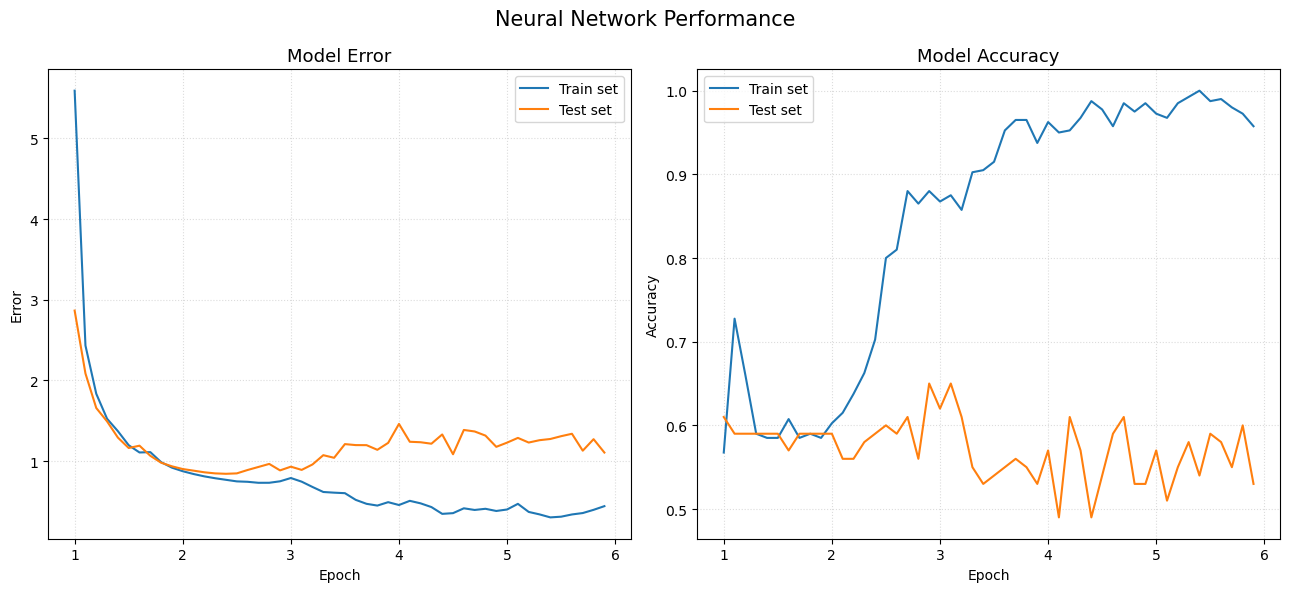

In [29]:
fig = plt.figure(figsize=(13,6))
loss = fig.add_subplot(1,2,1) 
accuracy = fig.add_subplot(1,2,2)

accuracy.plot(hist.history['accuracy'])
accuracy.plot(hist.history['val_accuracy'])
accuracy.set_title('Model Accuracy', fontsize=13)
accuracy.set_ylabel('Accuracy')
accuracy.set_xlabel('Epoch')
accuracy.set_xticklabels(range(0,9))
accuracy.legend(['Train set', 'Test set'], loc='best')
accuracy.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)

loss.plot(hist.history['loss'])
loss.plot(hist.history['val_loss'])
loss.set_title('Model Error', fontsize=13)
loss.set_ylabel('Error')
loss.set_xlabel('Epoch')
loss.set_xticklabels(range(0,9))
loss.legend(['Train set', 'Test set'], loc='best')
loss.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)

plt.suptitle('Neural Network Performance', fontsize=15)
plt.tight_layout()
plt.show()

In [35]:
val_acc = hist.history['val_accuracy']
val_acc.index(max(va_acc))

19

In [101]:
seed(1)
tf.random.set_seed(1)

#Initialize the model
plain_rnn_2 = Sequential()

# Add the Embedding layer, which maps each input integer (word) to a 300-dimensional vector.
#I am not using any pre-trained embeddings
plain_rnn_2.add(Embedding(len(tokenizer.word_index.items())+1, output_dim=300, trainable=True, embeddings_regularizer='l2',
                        embeddings_constraint=max_norm(3)))

# Add the RNN layer
plain_rnn_2.add(SimpleRNN(units=150, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',activation='tanh',
                        input_shape=x_train_pad.shape[1:], kernel_regularizer='l2', recurrent_regularizer='l2',
                        bias_regularizer='l2', kernel_constraint=max_norm(4), recurrent_constraint=max_norm(4),
                        bias_constraint=max_norm(4)))

# Add the final output layer
plain_rnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
plain_rnn_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
plain_rnn_2.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 300)         4726500   
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 150)               67650     
                                                                 
 dense_21 (Dense)            (None, 1)                 151       
                                                                 
Total params: 4,794,301
Trainable params: 4,794,301
Non-trainable params: 0
_________________________________________________________________


In [102]:
# Train the model with early stopping to get best results
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, verbose=1, patience=7)
hist=plain_rnn_2.fit(x_train_pad,y_train,batch_size=16,epochs=50,shuffle=True,validation_data=(x_test_pad,y_test),
                     callbacks=[es])

Epoch 1/50
25/25 [==============================] - 6s 147ms/step - loss: 17.9046 - accuracy: 0.5375 - val_loss: 7.2088 - val_accuracy: 0.4000
Epoch 2/50
25/25 [==============================] - 4s 160ms/step - loss: 4.4992 - accuracy: 0.7125 - val_loss: 3.0629 - val_accuracy: 0.5900
Epoch 3/50
25/25 [==============================] - 4s 163ms/step - loss: 2.5866 - accuracy: 0.6600 - val_loss: 2.3339 - val_accuracy: 0.5800
Epoch 4/50
25/25 [==============================] - 4s 144ms/step - loss: 2.0468 - accuracy: 0.9250 - val_loss: 2.0835 - val_accuracy: 0.5800
Epoch 5/50
25/25 [==============================] - 4s 179ms/step - loss: 1.7776 - accuracy: 0.9250 - val_loss: 1.9704 - val_accuracy: 0.5900
Epoch 6/50
25/25 [==============================] - 4s 148ms/step - loss: 1.7797 - accuracy: 0.8375 - val_loss: 2.1202 - val_accuracy: 0.5000
Epoch 7/50
25/25 [==============================] - 4s 142ms/step - loss: 1.8548 - accuracy: 0.9100 - val_loss: 2.0704 - val_accuracy: 0.5800
Epoch

## Results

**Regularized Model**

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

In [41]:
y_pred = plain_rnn.predict(x_test_pad)

4/4 [==============================] - 1s 27ms/step


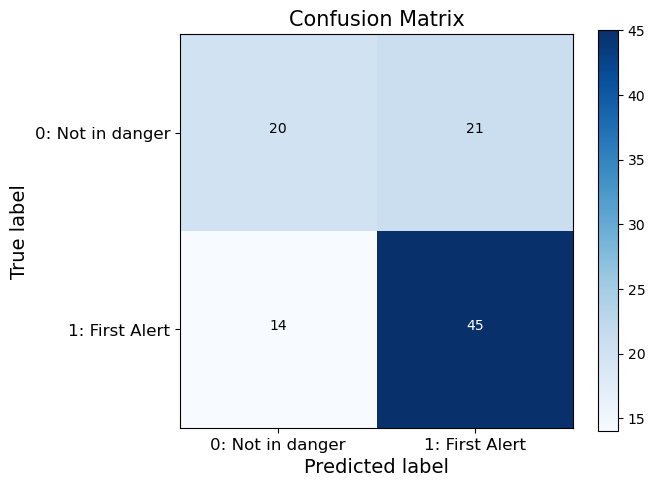

In [42]:
#Define a function for better visualization of Confusion Matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    

reg_rnn_cm = confusion_matrix(y_test, (y_pred >= .5).astype('int'), labels=[0,1])
plot_confusion_matrix(reg_rnn_cm, classes=['0: Not in danger', '1: First Alert'], title='Confusion Matrix')

In [43]:
print('Classification Report')
print(classification_report(y_test, (y_pred >= .5).astype('int'), labels=[0,1], target_names=['Not in danger', 'First Alert']))
print('ROC - Area Under the Curve: ', round(roc_auc_score(y_test, y_pred),2))

Classification Report
               precision    recall  f1-score   support

Not in danger       0.59      0.49      0.53        41
  First Alert       0.68      0.76      0.72        59

     accuracy                           0.65       100
    macro avg       0.64      0.63      0.63       100
 weighted avg       0.64      0.65      0.64       100

ROC - Area Under the Curve:  0.65


In [119]:
y_pred = plain_rnn_2.predict(x_train_pad)

13/13 [==============================] - 0s 27ms/step


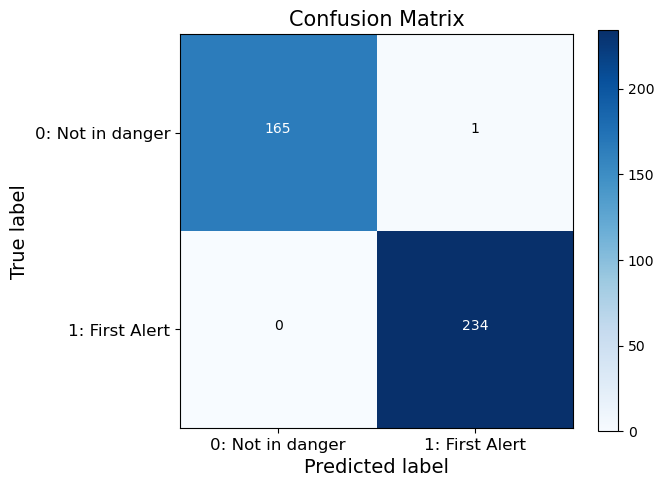

In [120]:
reg_rnn_cm = confusion_matrix(y_train, (y_pred >= .5).astype('int'), labels=[0,1])
plot_confusion_matrix(reg_rnn_cm, classes=['0: Not in danger', '1: First Alert'], title='Confusion Matrix')

In [126]:
print('Classification Report')
print(classification_report(y_train, (y_pred>=.5).astype('int'), labels=[0,1], target_names=['Not in danger', 'First Alert']))
print('ROC - Area Under the Curve: ', round(roc_auc_score(y_train, (y_pred>=.5).astype('int')),2))

Classification Report
               precision    recall  f1-score   support

Not in danger       1.00      0.99      1.00       166
  First Alert       1.00      1.00      1.00       234

     accuracy                           1.00       400
    macro avg       1.00      1.00      1.00       400
 weighted avg       1.00      1.00      1.00       400

ROC - Area Under the Curve:  1.0


---

**Not Regularized Model**

In [128]:
seed(1)
tf.random.set_seed(1)
#Initialize the model
plain_rnn = Sequential()

# Add the Embedding layer, which maps each input integer (word) to a 300-dimensional vector.
#I am not using any pre-trained embeddings
plain_rnn.add(Embedding(len(tokenizer.word_index.items())+1, output_dim=300, trainable=True, mask_zero=False))

# Add the RNN layer
plain_rnn.add(SimpleRNN(units=150, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',activation='tanh',
                        input_shape=x_train_pad.shape[1:]))

# Add the final output layer
plain_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
plain_rnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
plain_rnn.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 300)         4726500   
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, 150)               67650     
                                                                 
 dense_22 (Dense)            (None, 1)                 151       
                                                                 
Total params: 4,794,301
Trainable params: 4,794,301
Non-trainable params: 0
_________________________________________________________________


In [129]:
# Train the model
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, verbose=1, patience=7)
hist=plain_rnn.fit(x_train_pad,y_train,batch_size=16,epochs=10,shuffle=True,validation_data=(x_test_pad, y_test),callbacks=[es])

Epoch 1/10
25/25 [==============================] - 7s 138ms/step - loss: 0.6977 - accuracy: 0.5575 - val_loss: 0.6990 - val_accuracy: 0.5700
Epoch 2/10
25/25 [==============================] - 3s 101ms/step - loss: 0.4940 - accuracy: 0.7700 - val_loss: 0.6886 - val_accuracy: 0.5800
Epoch 3/10
25/25 [==============================] - 3s 112ms/step - loss: 0.1563 - accuracy: 0.9775 - val_loss: 0.7387 - val_accuracy: 0.5800
Epoch 4/10
25/25 [==============================] - 3s 107ms/step - loss: 0.0881 - accuracy: 0.9775 - val_loss: 1.0136 - val_accuracy: 0.5700
Epoch 5/10
25/25 [==============================] - 3s 117ms/step - loss: 0.0494 - accuracy: 0.9925 - val_loss: 0.7702 - val_accuracy: 0.5800
Epoch 6/10
25/25 [==============================] - 3s 117ms/step - loss: 0.0178 - accuracy: 0.9975 - val_loss: 1.0278 - val_accuracy: 0.5300
Epoch 7/10
25/25 [==============================] - 3s 113ms/step - loss: 0.0240 - accuracy: 0.9950 - val_loss: 1.0534 - val_accuracy: 0.5800
Epoch 

In [133]:
y_pred = plain_rnn.predict(x_test_pad)

4/4 [==============================] - 0s 21ms/step


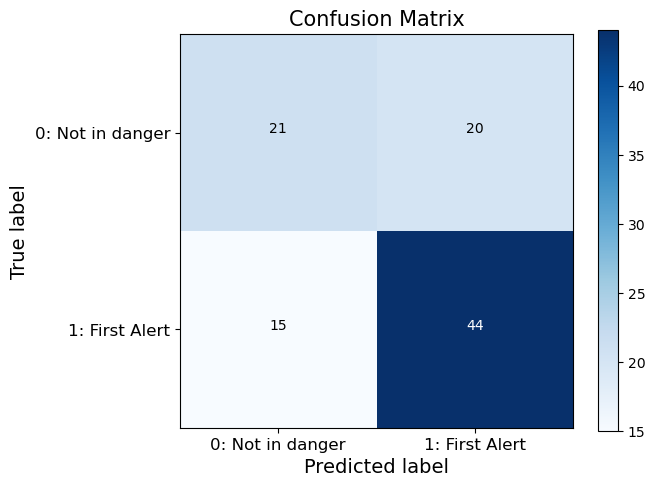

In [134]:
reg_rnn_cm = confusion_matrix(y_test, (y_pred >= .5).astype('int'), labels=[0,1])
plot_confusion_matrix(reg_rnn_cm, classes=['0: Not in danger', '1: First Alert'], title='Confusion Matrix')

In [136]:
print('Classification Report')
print(classification_report(y_test, (y_pred >= .5).astype('int'), labels=[0,1], target_names=['Not in danger', 'First Alert']))
print('ROC - Area Under the Curve: ', round(roc_auc_score(y_test, y_pred),2))

Classification Report
               precision    recall  f1-score   support

Not in danger       0.58      0.51      0.55        41
  First Alert       0.69      0.75      0.72        59

     accuracy                           0.65       100
    macro avg       0.64      0.63      0.63       100
 weighted avg       0.64      0.65      0.65       100

ROC - Area Under the Curve:  0.63


In [137]:
y_pred = plain_rnn.predict(x_train_pad)

13/13 [==============================] - 0s 29ms/step


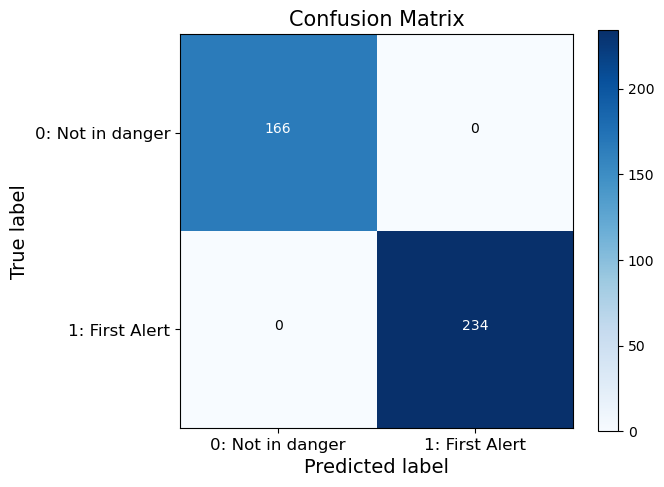

In [138]:
reg_rnn_cm = confusion_matrix(y_train, (y_pred >= .5).astype('int'), labels=[0,1])
plot_confusion_matrix(reg_rnn_cm, classes=['0: Not in danger', '1: First Alert'], title='Confusion Matrix')

In [139]:
print('Classification Report')
print(classification_report(y_train, (y_pred>=.5).astype('int'), labels=[0,1], target_names=['Not in danger', 'First Alert']))
print('ROC - Area Under the Curve: ', round(roc_auc_score(y_train, (y_pred>=.5).astype('int')),2))

Classification Report
               precision    recall  f1-score   support

Not in danger       1.00      1.00      1.00       166
  First Alert       1.00      1.00      1.00       234

     accuracy                           1.00       400
    macro avg       1.00      1.00      1.00       400
 weighted avg       1.00      1.00      1.00       400

ROC - Area Under the Curve:  1.0


---

Extras:
1. can I do cross validation / hyperparameters tuning with deep learnig models: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/#:~:text=By%20setting%20the%20n_jobs%20argument,for%20each%20combination%20of%20parameters.

---

sources for data-preprocessing (NLP):
- https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
- https://medium0.com/@saad.arshad102/sentiment-analysis-text-classification-using-rnn-bi-lstm-recurrent-neural-network-81086dda8472

---

data source: https://www.kaggle.com/datasets/thedevastator/c-ssrs-labeled-suicidality-in-500-anonymized-red
https://zenodo.org/record/2667859#.Y9aqCXZBw2z